# GenAI in Education — Cleaning & EDA
Notebook to explore and clean the scraped dataset, then export a cleaned CSV.

**Steps included**
1. Load RAW dataset
2. Explore (missing values, top sources, date distribution, text length)
3. Cleaning pipeline (normalize text, standardize dates, fill/derive source names, validate links, deduplicate)
4. Save cleaned CSV


In [20]:
import re, unicodedata
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INPUT_PATH = "data/raw_genai-education_2023-2025.csv"
OUTPUT_PATH = "data/clean_genai-education_2023-2025.csv"

pd.set_option("display.max_colwidth", 200)

In [54]:
df = pd.read_csv(INPUT_PATH)
print("Rows, Columns:", df.shape)
df.head(3)

Rows, Columns: (463, 4)


,source_name,date,text,link
0,Reddit,May 2025,"Generative AI, most notably ChatGPT, has and is continuing to change the landscape of education. But this also comes with negative side effects, especially students relying on AI to plagirize thei...",https://www.reddit.com/r/edtech/comments/1l5b9t0/thoughts_on_usage_of_ai_in_school_coursework/
1,Gizmodo,2025-08-16 12:00:42+00:00,"Film Schools Are Embracing AI. Should They? Generative AI has come for America's film students. Jake Panek, a 20-year-old film major, says he’s had a great time at DePaul University in Chicago, an...",https://gizmodo.com/film-schools-are-embracing-ai-should-they-2000639311
2,Windows Central,2025-08-19 15:11:27+00:00,"Ex-Google GenAI founder says ""AI is going to be gone by the time you finish a PhD"" — higher education degrees can't keep up Jad Tarifi, founder of Google’s first generative AI team, says pursuing ...",https://www.windowscentral.com/artificial-intelligence/ex-google-genai-founder-ai-gone-by-the-time-you-finish-phd


In [22]:
df.isnull().sum().to_frame("missing_count")

,missing_count
source_name,1
date,6
text,0
link,1


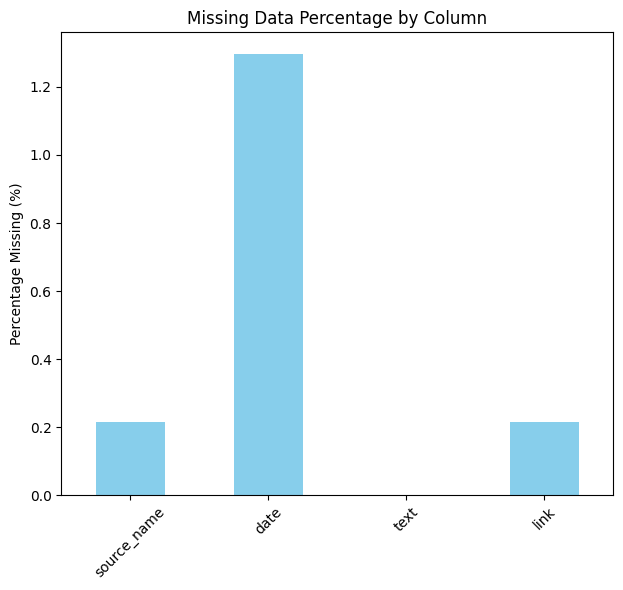

Dataset completeness: 99.6%


In [23]:
# Visualize missing data patterns
import seaborn as sns
plt.figure(figsize=(12, 6))

# Missing data percentage by column
plt.subplot(1, 2, 2)
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_pct.plot(kind='bar', color='skyblue')
plt.title('Missing Data Percentage by Column')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Dataset completeness: {((1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100):.1f}%")

In [24]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
TRUNCATION_RE = re.compile(r"\.\s*\[\+\d+\s*chars\]", flags=re.IGNORECASE)  # e.g., "... [+7735 chars]"

def is_valid_url(url: str) -> bool:
    if not isinstance(url, str) or not url.strip():
        return False
    try:
        u = urlparse(url)
        return bool(u.scheme and u.netloc)
    except Exception:
        return False

def normalize_confusables(text: str) -> str:
    """
    Normalize Unicode punctuation likely to be confused in source text.
    NOTE: You asked specifically to treat U+2019 (’ right single quote)
    as the ASCII backtick U+0060 (`), since that's more common in your source.
    """
    if not isinstance(text, str):
        return text
    # First do NFKC normalization to reduce odd forms
    text = unicodedata.normalize("NFKC", text)

    # Map of confusables -> target ASCII
    # You can extend this mapping to include more punctuation if needed.
    confusables_map = {
        "\u2019": "`",  # RIGHT SINGLE QUOTATION MARK ’ -> backtick `
        "\u2018": "`",  # LEFT SINGLE QUOTATION MARK ‘ -> backtick `
        "\u201C": '"',  # LEFT DOUBLE QUOTATION MARK “ -> "
        "\u201D": '"',  # RIGHT DOUBLE QUOTATION MARK ” -> "
        "\u00B4": "`",  # ACUTE ACCENT ´ -> `
        "\u2032": "'",  # PRIME ′ -> '
        "\u2033": '"',  # DOUBLE PRIME ″ -> "
        "\u2014": "-",  # EM DASH — -> -
        "\u2013": "-",  # EN DASH – -> -
        "\u00A0": " ",  # NO-BREAK SPACE -> regular space
    }
    # Translate using a table
    trans_table = str.maketrans(confusables_map)
    text = text.translate(trans_table)

    # Collapse excessive whitespace
    text = " ".join(text.split())
    return text

def replace_specials(text: str) -> str:
    """Replace URLs/emails inside text with placeholders (keep semantics)."""
    if not isinstance(text, str):
        return text
    text = URL_RE.sub("<URL>", text)
    text = EMAIL_RE.sub("<EMAIL>", text)
    return text

def coerce_date_any(x):
    """
    Robust date parsing:
    - Try pandas to_datetime (handles ISO and many formats).
    - If fail, try Month Year (e.g., 'May 2025').
    Returns timezone-aware UTC timestamps or NaT.
    """
    if pd.isna(x):
        return pd.NaT
    dt = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(dt):
        try:
            dt = pd.to_datetime(str(x), format="%B %Y", utc=True)
        except Exception:
            dt = pd.NaT
    return dt

def impute_missing_dates(series_dt: pd.Series, group_keys=None) -> pd.Series:
    """
    Impute NaT dates.
    Strategy:
      1) If group_keys provided (e.g., by source), impute with group median.
      2) Fallback to global median.
      3) If all missing, keep as NaT.
    """
    s = series_dt.copy()

    # Helper to compute safe median for datetime64[ns, UTC]
    def _median_datetime(x: pd.Series):
        x = x.dropna()
        if x.empty:
            return pd.NaT
        # Convert to int64 ns to compute median, then back
        vals = x.view("int64").sort_values().to_numpy()
        med = np.median(vals)
        try:
            return pd.to_datetime(int(med), utc=True)
        except Exception:
            return pd.NaT

    if group_keys is not None:
        med_by_group = s.groupby(group_keys, dropna=False).transform(_median_datetime)
        s = s.fillna(med_by_group)

    global_med = _median_datetime(s)
    if pd.isna(global_med):
        # nothing to impute with; return as-is
        return s

    s = s.fillna(global_med)
    return s

def std_source_name(name: str) -> str:
    """
    Standardize source name:
    - Strip whitespace
    - Handle None/NaN values gracefully
    - Maintain case for ALL CAPS names
    - Title case for other names
    """
    if not isinstance(name, str) or not name.strip():
        return None
        
    name = name.strip()
    
    # If name is all uppercase, keep it that way
    if name.isupper():
        return name
    
    # Otherwise title case (capitalize first letter of each word)
    return name.title()

In [45]:
df['source_name_norm'] = df['source_name'].apply(std_source_name)
df['source_name_norm'].fillna("Unknown").value_counts().head(20)

source_name_norm
Universityofliverpool    143
Reddit                   106
Zenodo                    61
X                         33
Aimultiple                10
Presbooks                 10
Stratxsimulations          8
Fullestop Blog             8
Youtube                    8
Nafsa                      7
Nationalcentreforai        7
Weforum                    6
Eklavvya Blog              6
Educationhorizons          5
Inside Higher Ed           4
Cyberbullying . Org        4
Kasigaschool               3
Windows Central            3
Ed Week                    2
Gizmodo                    2
Name: count, dtype: int64

Text(0.5, 1.0, 'Source Distribution (Top 10 + Others)')

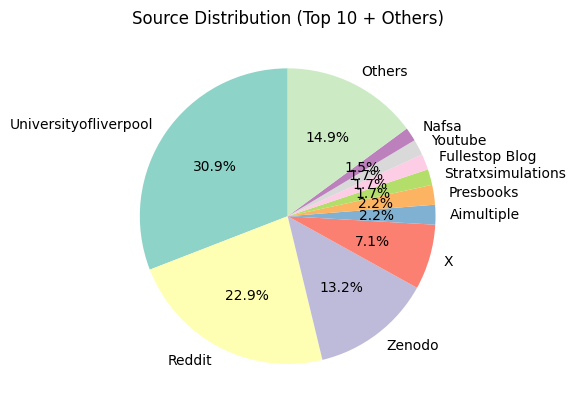

In [ ]:
# Source distribution pie chart (top 10 + others)
plt.plot(2, 2, 2)
top_10_sources = df['source_name_norm'].fillna("Unknown").value_counts().head(10)
others_count = df['source_name_norm'].fillna("Unknown").value_counts().iloc[10:].sum()
pie_data = top_10_sources.copy()
if others_count > 0:
    pie_data['Others'] = others_count

colors = plt.cm.Set3(range(len(pie_data)))
plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', 
        startangle=90, colors=colors)



In [ ]:
print(f"Total unique sources: {df['source_name_norm'].nunique()}")
print(f"Sources with unknown names: {df['source_name_norm'].isnull().sum()}")
print(f"Top 10 sources cover {top_10_sources.sum() / len(df) * 100:.1f}% of all articles")

Total unique sources: 45
Sources with unknown names: 1
Top 10 sources cover 85.1% of all articles


Parsed date coverage: 0.978401727861771


/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_97658/1175482285.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly['year_month'] = monthly['_date_parsed'].dt.to_period('M').astype(str)


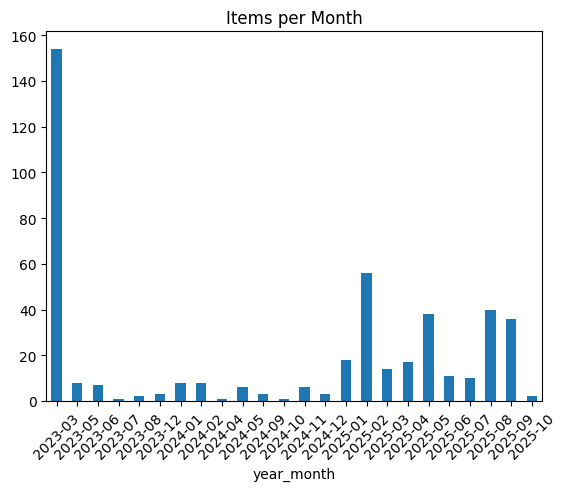

In [46]:
df['_date_parsed'] = df['date'].apply(coerce_date_any)
print("Parsed date coverage:", df['_date_parsed'].notna().mean())

monthly = df.dropna(subset=['_date_parsed']).copy()
if not monthly.empty:
    monthly['year_month'] = monthly['_date_parsed'].dt.to_period('M').astype(str)
    counts = monthly['year_month'].value_counts().sort_index()
    counts.plot(kind='bar', rot=45, title='Items per Month')

In [32]:
df['text_len'] = df['text'].astype(str).str.len()
df['text_len'].describe(percentiles=[.5,.9,.95,.99])

count     463.000000
mean      357.928726
std       478.808321
min        33.000000
50%       221.000000
90%       723.200000
95%      1044.100000
99%      1983.300000
max      7081.000000
Name: text_len, dtype: float64

<Axes: title={'center': 'Text Length Distribution'}, ylabel='Frequency'>

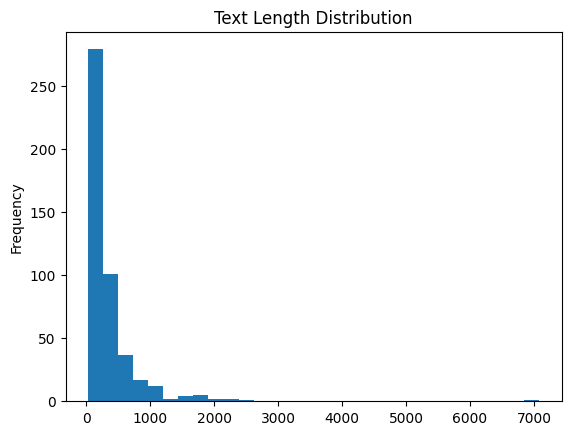

In [33]:
df['text_len'].dropna().plot(kind='hist', bins=30, title='Text Length Distribution')

## Cleaning Pipeline

In [35]:
clean = df.copy()

# 0) Basic trims; keep missing source names (do NOT drop)
for col in ["source_name", "text", "link", "date"]:
    if col in clean.columns:
        clean[col] = clean[col].apply(lambda x: x if not isinstance(x, str) else x.strip())

# 0.5) Remove rows with empty text fields
before_empty = len(clean)
# Check for None, NaN, empty strings, or whitespace-only strings
empty_text_mask = clean["text"].isna() | (clean["text"].astype(str).str.strip() == "")
if empty_text_mask.any():
    clean = clean[~empty_text_mask].copy()
    print(f"Removed {before_empty - len(clean)} rows with empty text fields.")
else:
    print("No empty text fields found.")

# 1) Normalize confusables (e.g., ’ -> `), collapse whitespace
clean["text_norm"] = clean["text"].apply(normalize_confusables)

# 1.5) Improve text quality filtering
MIN_TEXT_LENGTH = 20
mask_short = clean["text_norm"].astype(str).str.len() < MIN_TEXT_LENGTH
if mask_short.any():
    print(f"Removing {mask_short.sum()} entries with text shorter than {MIN_TEXT_LENGTH} chars.")
    clean = clean[~mask_short].copy()

# Add text metrics
clean["word_count"] = clean["text_norm"].astype(str).str.split().apply(len)
clean["all_caps"] = clean["text_norm"].astype(str).str.isupper()
clean["suspicious_repetition"] = clean["text_norm"].astype(str).str.contains(r'(.)\\1{4,}')  # 5+ repeated chars

# 2) Replace specials (URLs/emails) but keep semantics
clean["text_clean"] = clean["text_norm"].apply(replace_specials)

# 3) Drop rows where text contains truncation markers like "... [+7735 chars]"
mask_trunc = clean["text_clean"].astype(str).str.contains(TRUNCATION_RE)
clean = clean[~mask_trunc].copy()

# 4) Validate link (keep rows even if link missing/invalid; we just flag it)
clean["link_valid"] = clean["link"].apply(is_valid_url)

# 5) Parse dates, then IMPUTE missing dates (do not drop)
clean["date_parsed"] = clean["date"].apply(coerce_date_any)

# Impute by source_name first (preserving missing source names by treating NaN as its own group),
# then fallback to global median.
clean["date_imputed"] = impute_missing_dates(clean["date_parsed"], group_keys=clean["source_name"])

# 6) Deduplicate:
#    Keep rows with the same link UNLESS the text is different.
#    That means we remove *exact* duplicates only when both 'link' and 'text_clean' match.
before = len(clean)
clean = clean.drop_duplicates(subset=["link", "text_clean"], keep="first")
after = len(clean)
print(f"Removed {before - after} exact duplicates on (link, text_clean).")

# 6.5) Fuzzy deduplication (for small datasets)
from difflib import SequenceMatcher
def fuzzy_dedupe(df, text_col, threshold=0.9):
    texts = df[text_col].tolist()
    n = len(texts)
    duplicates = set()
    for i in range(n):
        if i in duplicates:
            continue
        for j in range(i+1, n):
            if j in duplicates:
                continue
            if len(texts[i]) > 100 and len(texts[j]) > 100:
                similarity = SequenceMatcher(None, texts[i][:500], texts[j][:500]).ratio()
                if similarity >= threshold:
                    duplicates.add(j)
    keep_mask = ~df.index.isin([df.index[list(duplicates)]]) if duplicates else [True]*n
    print(f"Removed {len(duplicates)} fuzzy duplicates with threshold {threshold}")
    return df[keep_mask].copy() if duplicates else df

if len(clean) < 1000:
    clean = fuzzy_dedupe(clean, "text_clean", threshold=0.9)

No empty text fields found.
Removed 4 exact duplicates on (link, text_clean).


/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_97658/2304314127.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clean["suspicious_repetition"] = clean["text_norm"].astype(str).str.contains(r'(.)\\1{4,}')  # 5+ repeated chars


Removed 3 fuzzy duplicates with threshold 0.9


In [52]:
# 7) Final selection (do NOT drop missing source names)
out = clean.copy()
out = out.rename(columns={"date_imputed": "date_clean"})
# Derive missing source names from URLs
def domain_from_url(url):
    if not isinstance(url, str) or not url.strip():
        return None
    try:
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        domain = re.sub(r'^www\\.', '', domain)
        return domain
    except Exception:
        return None
out["source_domain"] = out["link"].apply(domain_from_url)
out["source_name"] = out["source_name"].fillna(out["source_domain"])
# Keep both original and cleaned variants for auditability if you like; otherwise select minimal columns:
out = out[[
    "source_name",       # filled from domain if missing
    "date_clean",        # imputed date (never NaT if median existed)
    "text_clean",        # normalized + placeholders
    "link",
]].reset_index(drop=True)

out.to_csv(OUTPUT_PATH, index=False)

In [38]:
out['source_name'].fillna('Unknown').value_counts().head(10)

source_name
universityofliverpool    143
Reddit                   106
Zenodo                    60
X                         30
AIMultiple                10
PresBooks                 10
Fullestop Blog             8
stratxsimulations          8
Youtube                    8
nationalcentreforai        7
Name: count, dtype: int64